In [43]:
from tqdm import tqdm

import numpy as np

import pandas as pd

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [44]:
df = pd.read_csv('../data/housing/housing.csv')
df = df.dropna()

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>, <Axes: >]],
      dtype=object)

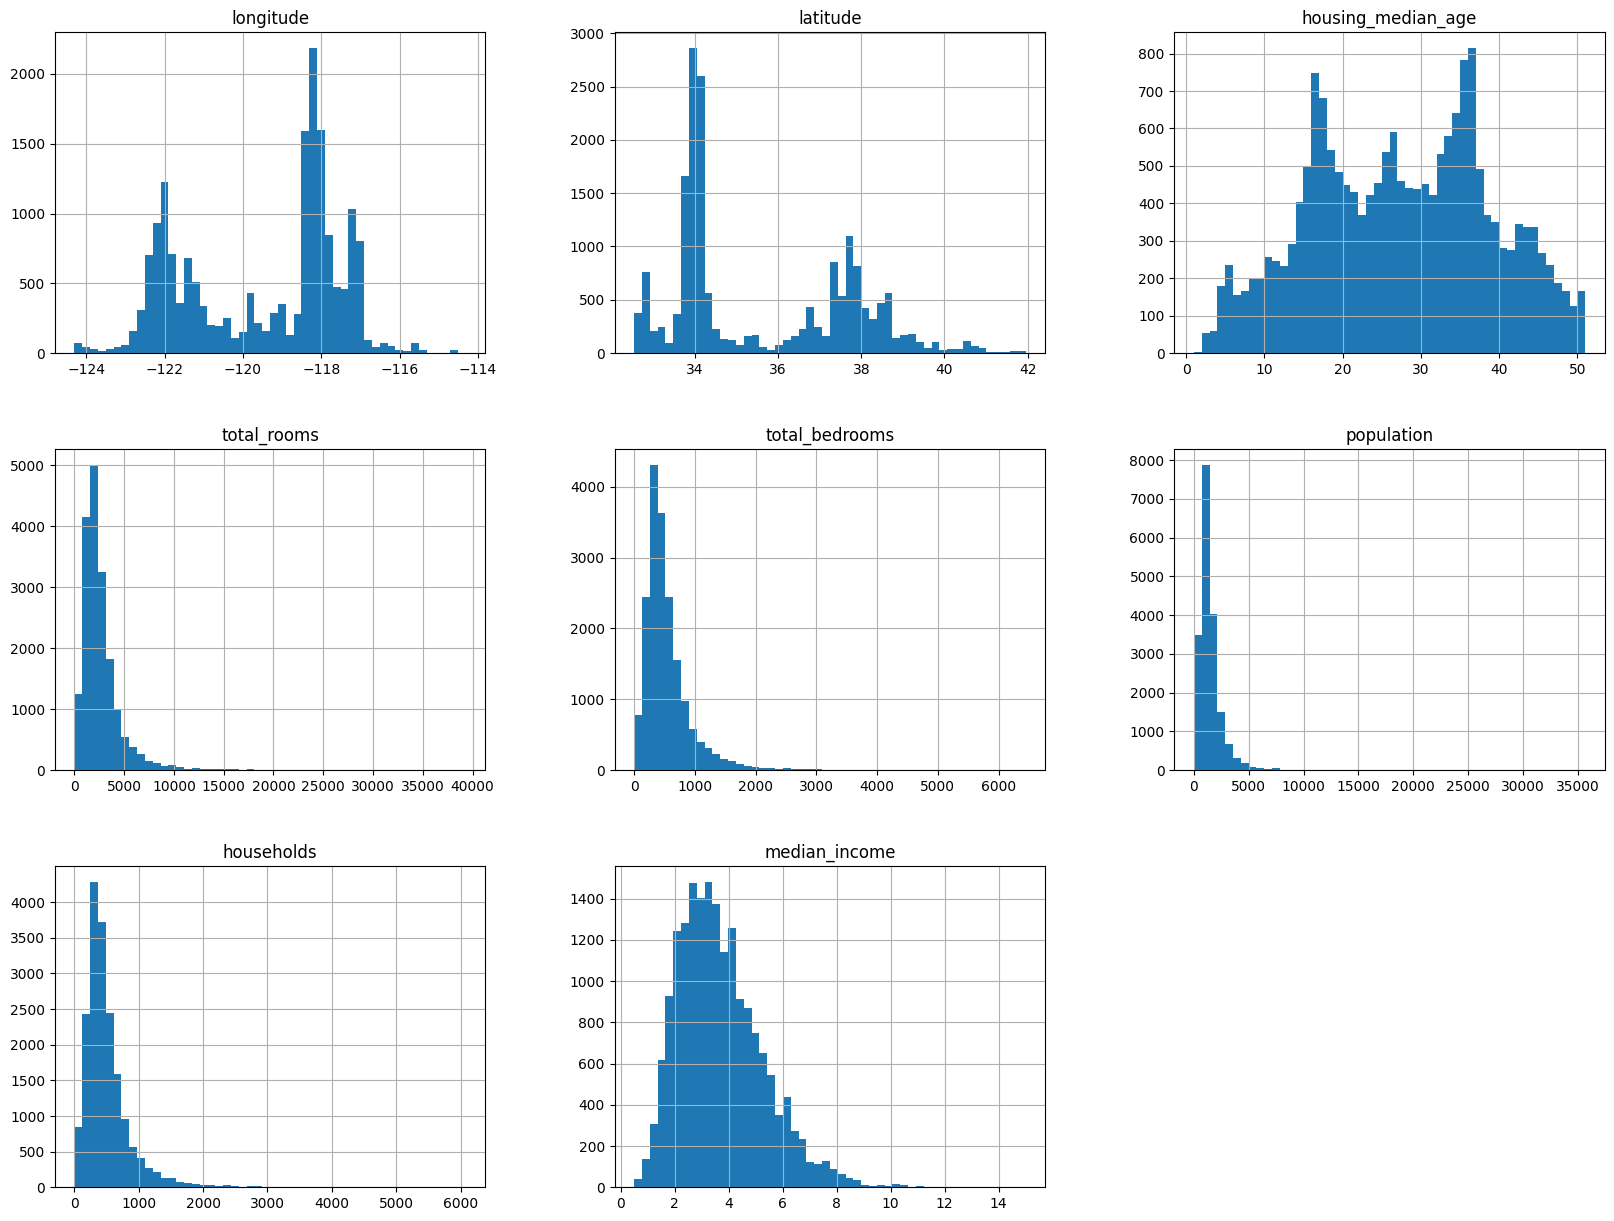

In [45]:
numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
categorical_columns = ['ocean_proximity']
target_column = 'median_house_value'

median_house_value_mask = df['median_house_value'] != df['median_house_value'].max()
housing_median_age_mask = df['housing_median_age'] != df['housing_median_age'].max()

df = df[(median_house_value_mask & housing_median_age_mask).to_list()]

df[numerical_columns].hist(bins=50, figsize=(20, 15))

In [46]:
# def tukey_fences(series, k=1.5):
#     q1 = series.quantile(0.25)
#     q3 = series.quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - k * iqr
#     upper_bound = q3 + k * iqr
#     outlier = (series < lower_bound) | (series > upper_bound)
#     series[outlier] = series.median()
#     return series


# df.loc[:, numerical_columns] = df[numerical_columns].apply(tukey_fences, axis=0)

df[categorical_columns] = df[categorical_columns].apply(pd.Categorical)

In [47]:
X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
print("Best model:", best_model)

r2 = best_model.score(X_test, y_test)
print("Test R2:", r2)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learni

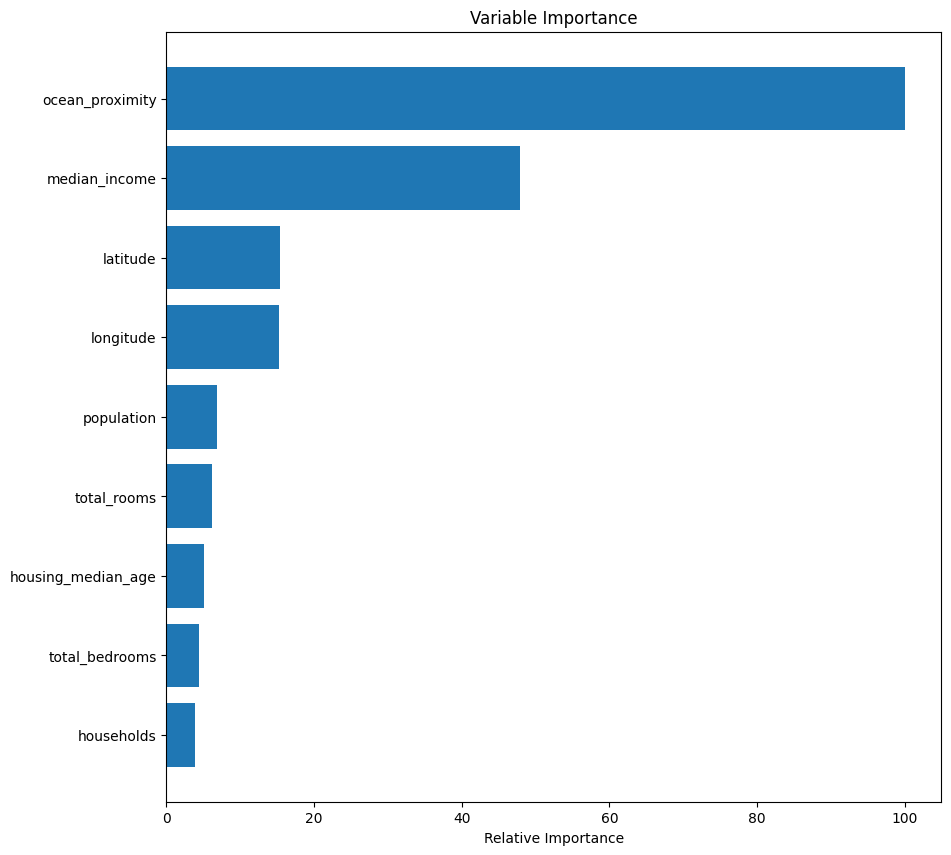

In [50]:
# compute feature importance
import matplotlib.pyplot as plt
feature_importance = best_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [51]:

# transformers = {}
# transfomer_columns = numerical_columns + [target_column]
# for column in transfomer_columns:
#     transformer = QuantileTransformer(output_distribution='normal')
#     df[column] = transformer.fit_transform(df[column].values.reshape(-1, 1))
#     transformers[column] = transformer

# df = pd.get_dummies(df, columns=categorical_columns).astype(float)

# df[numerical_columns].hist(bins=50, figsize=(20, 15))

In [52]:
# X = df.drop(columns=[target_column])
# y = df[target_column]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# dataset = TensorDataset(X_train_tensor, y_train_tensor)
# dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

# import torch.nn as nn

# import torch.nn as nn

# import torch.nn as nn

# import torch.nn as nn

# class MultiLayerPerceptron(nn.Module):
#     def __init__(self, input_dim, dropout_prob=0.1):
#         super(MultiLayerPerceptron, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, 1024),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(1024, 512),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(512, 256),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(256, 128),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(128, 64),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(64, 32),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(32, 16),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(16, 8),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(8, 4),
#             # nn.ReLU(),
#             nn.Tanh(),
#             nn.Linear(4, 1)
#         )

#     def forward(self, x):
#         return self.layers(x).unsqueeze(-1)

# device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# model = MultiLayerPerceptron(input_dim=X_train.shape[1]).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500)

# epochs = 5000
# progress_bar = tqdm(range(epochs))
# for epoch in progress_bar:
#     model.train()
#     epoch_loss = 0.0

#     for X_batch, y_batch in dataloader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         optimizer.zero_grad()
#         y_pred = model(X_batch)
#         loss = F.mse_loss(y_pred.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * len(X_batch)

#     epoch_loss /= len(dataloader.dataset)

#     model.eval()
#     with torch.no_grad():
#         y_pred = model(X_test_tensor.to(device))
#         mae = F.l1_loss(y_pred.squeeze(), y_test_tensor.to(device)).item()
#         mae_median_house_value = transformers[target_column].inverse_transform([[mae]])[0][0]

#     progress_bar.set_description(f"Loss: {epoch_loss:.4f}, MAE Median House Value: {mae_median_house_value:.4f}")

#     # scheduler.step(epoch_loss)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>, <Axes: >]],
      dtype=object)

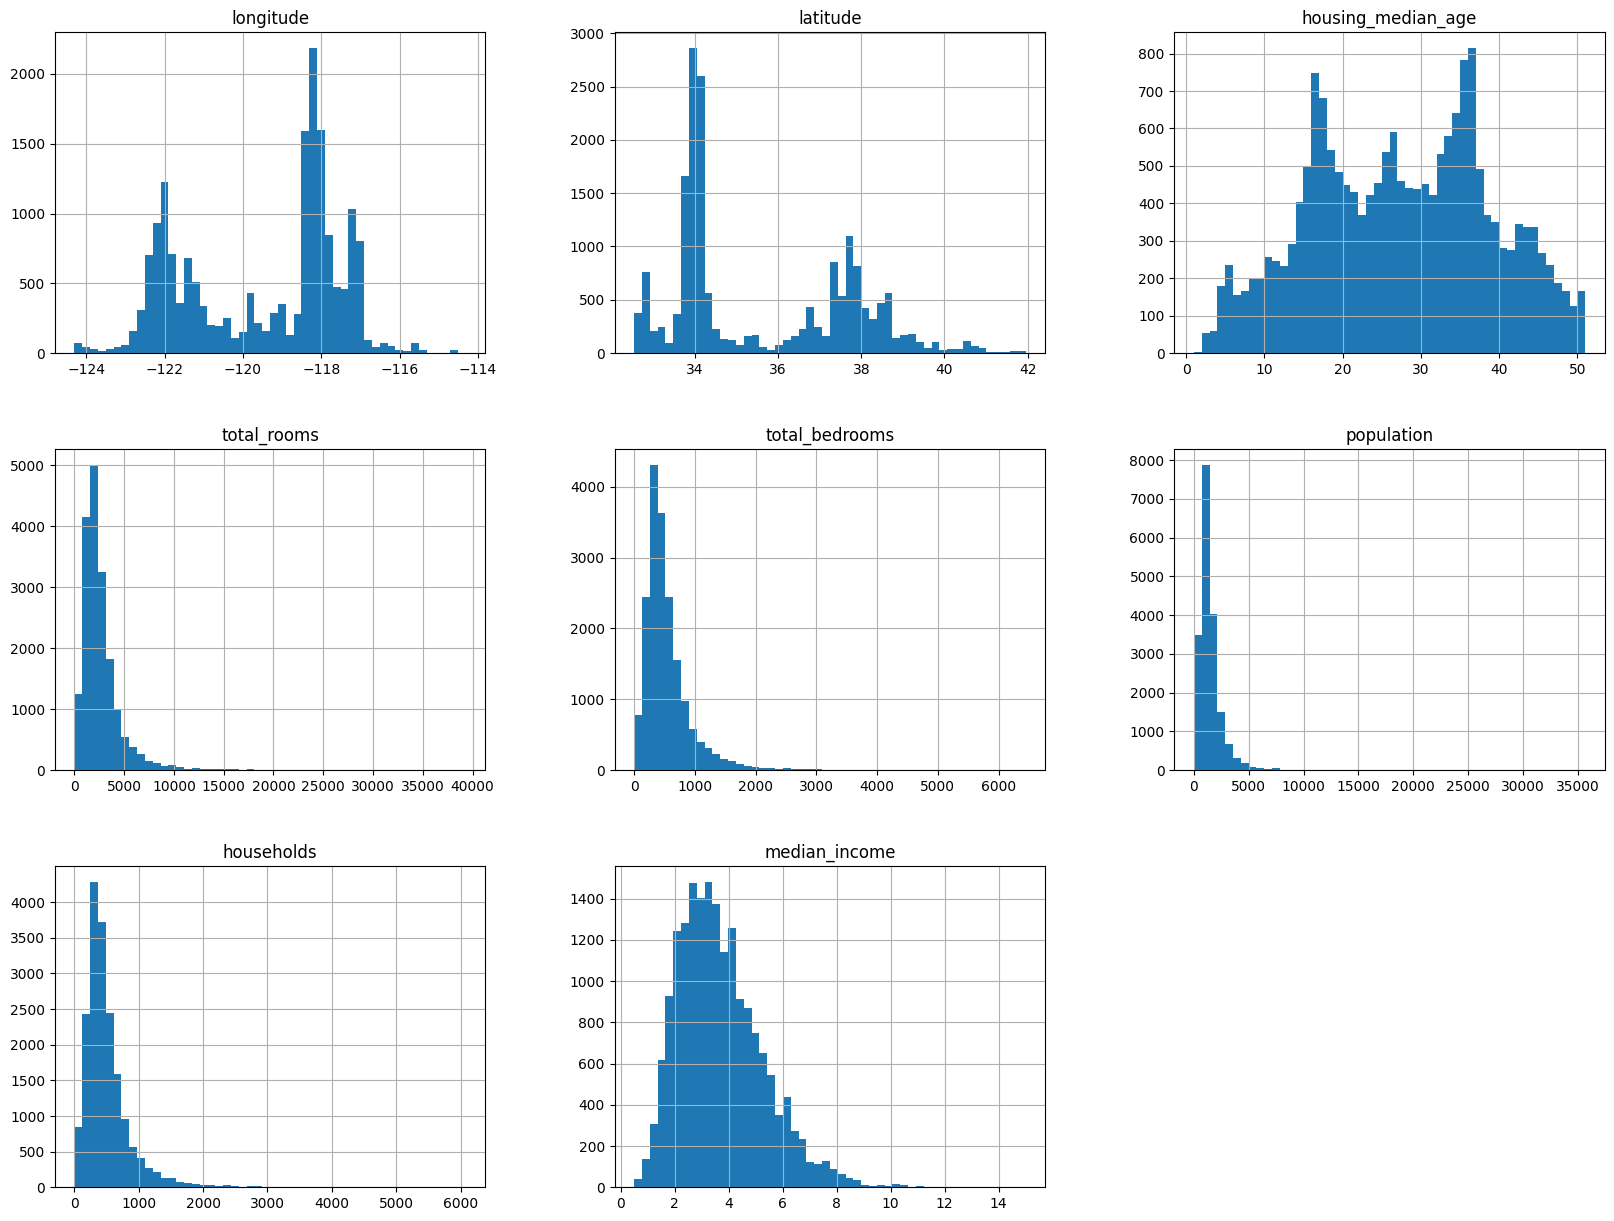

In [19]:
import pandas as pd

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

df = pd.read_csv('../data/housing/housing.csv')
df = df.dropna()

numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
categorical_columns = ['ocean_proximity']
target_column = 'median_house_value'

median_house_value_mask = df['median_house_value'] != df['median_house_value'].max()
housing_median_age_mask = df['housing_median_age'] != df['housing_median_age'].max()

df = df[(median_house_value_mask & housing_median_age_mask).to_list()]

# df = pd.get_dummies(df, columns=categorical_columns).astype(float)
df[categorical_columns] = df[categorical_columns].apply(pd.Categorical)

df[numerical_columns].hist(bins=50, figsize=(20, 15))

In [20]:
X = df.drop(columns=[target_column])
y = df[target_column]

pca = PCA()
X[numerical_columns] = pca.fit_transform(X[numerical_columns])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [21]:
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
print("Best model:", best_model)

r2 = best_model.score(X_test, y_test)
print("Test R2:", r2)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learni